In [2]:
import pandas as pd #data manpulation
import numpy as np #arrays
import matplotlib.pyplot as plt #plotting
from sklearn.metrics import  confusion_matrix #evalution
from sklearn.model_selection import train_test_split #splitting probabilty

import os #access desktop
import cv2 #image manputlaion


# model building
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

In [8]:
train_path = "/content/drive/MyDrive/Training/Training"
test_path = "/content/drive/MyDrive/Testing/Testing"

labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


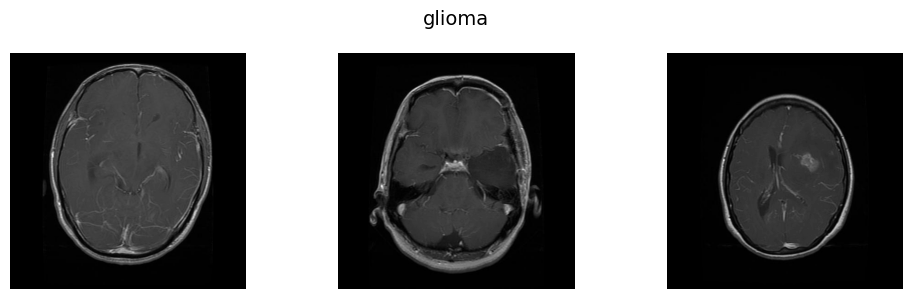

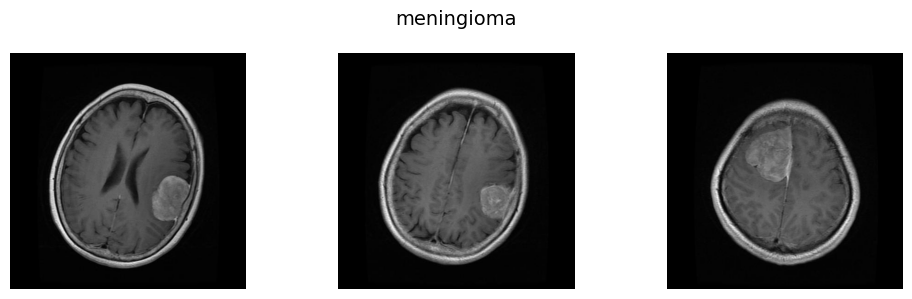

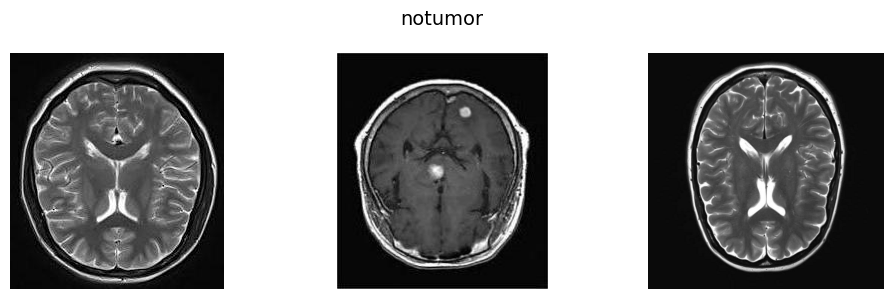

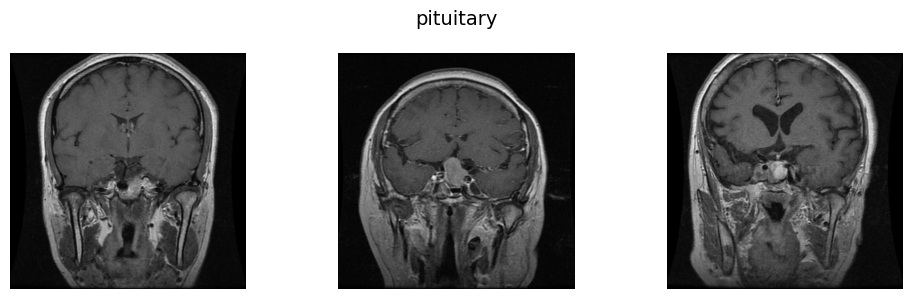

In [9]:
def display_samples(data_path, labels, num_samples=3):
    for label in labels.keys(): # Changed here to iterate over keys
        images = [cv2.imread(os.path.join(data_path, label, img), cv2.IMREAD_GRAYSCALE) # reading the data from the path
                  for img in os.listdir(os.path.join(data_path, label))[:num_samples]]
        #plot sample of the data
        plt.figure(figsize=(10, 3))
        for i, img in enumerate(images):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
        plt.suptitle(label, fontsize=14)
        plt.tight_layout()
        plt.show()

display_samples(train_path, labels) # Call the function

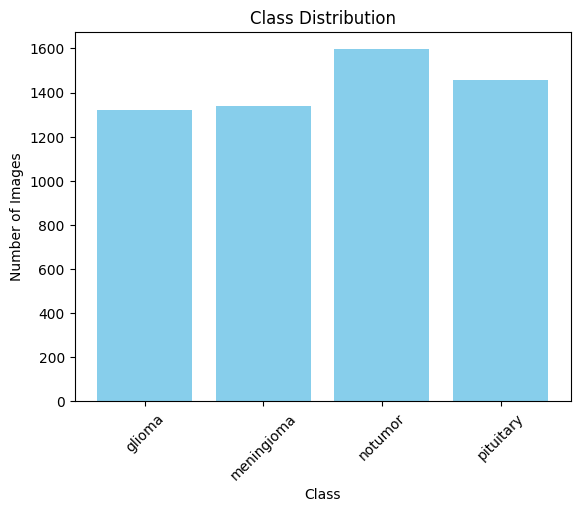

In [10]:
def class_counts(data_path, labels):
    counts = [] # store count data
    for label in labels:
        counts.append(len(os.listdir(os.path.join(data_path, label)))) # acces data path

    plt.bar(labels.keys(), counts, color='skyblue')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

class_counts(train_path, labels)

In [11]:
def load_images(data_path, labels, target_size=(224, 224)):
    images = [] # store images
    classes = [] # store labels
    for label, class_index in labels.items():
        class_path = os.path.join(data_path, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)
            images.append(img)
            classes.append(class_index)
    images = np.array(images, dtype='float32')   # convert to numpy arrays
    classes = np.array(classes)
    return images, classes

train_images, train_labels = load_images(train_path, labels)
test_images, test_labels = load_images(test_path, labels)

In [12]:
# image normalization  [0,255] >>> [0,1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [13]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (5712, 224, 224)
Train labels shape: (5712,)
Test images shape: (1311, 224, 224)
Test labels shape: (1311,)


In [14]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.3, random_state=42)

In [15]:
# convert the arrays to categorical
train_labels = to_categorical(train_labels, num_classes=len(labels))
val_labels = to_categorical(val_labels, num_classes=len(labels))
test_labels = to_categorical(test_labels, num_classes=len(labels))

In [28]:
#cnn model
from tensorflow.keras.metrics import Precision, Recall
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)), # layer 1
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'), #layer 2
    MaxPooling2D(pool_size=(2, 2)),

    # fully connected
    Flatten(), # convert 2d arrays to 1d
    Dense(128, activation='relu'),
    Dropout(0.5),  # prevents overfitting
    Dense(4, activation='softmax')])  # output layer 4 for each class

model.compile(
    optimizer='adam', #lr = 0.01
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,332 (91.20 MB)

 Trainable params: 23,907,332 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#model training
trained_model = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    batch_size=32
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.5432 - loss: 1.1715 - precision: 0.6358 - recall: 0.3697 - val_accuracy: 0.8588 - val_loss: 0.4502 - val_precision: 0.8924 - val_recall: 0.8174
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.8433 - loss: 0.4212 - precision: 0.8706 - recall: 0.8054 - val_accuracy: 0.8985 - val_loss: 0.3025 - val_precision: 0.9114 - val_recall: 0.8886
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.8932 - loss: 0.2868 - precision: 0.9053 - recall: 0.8836 - val_accuracy: 0.8786 - val_loss: 0.3148 - val_precision: 0.8865 - val_recall: 0.8751
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.9246 - loss: 0.1938 - precision: 0.9295 - recall: 0.9168 - val_accuracy: 0.9201 - val_loss: 0.2407 - val_precision: 0.9219 - val_recall: 0.9160
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - accuracy: 0.9538 - loss: 0.1310 - precision: 0.9564 - recall: 0.9482 - val_accuracy: 0.9154 - val_los

In [30]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_images, test_labels)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 873ms/step - accuracy: 0.9065 - loss: 0.3474 - precision: 0.9075 - recall: 0.9060
Test Loss: 0.3036
Test Accuracy: 0.9199
Test Precision: 0.9220
Test Recall: 0.9191
